In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import time
import matplotlib.pyplot as plt
import torch, torch.nn as nn
import norse
import sys
import norse.torch as norse
from time import perf_counter
from array2gif import write_gif

# Dataset creation
We simulate a set of movements (to the left, to the right, up and down) as if they were outputs of a DVS camera.

In [2]:
# x = 287 
# y = 287
x = 41 
y = 41       #Size of our input. For simplicity, we use a square image
dt = 0.001   #Timestep of our simulation
duration = 1 #Duration of the movement

x_p = 3                    #Size of the object moving within the frame
y_p = 3
point = np.ones((x_p,y_p))

In [3]:
def set_params(x, y, dt):
    if x!=y :
        nb_samples = int((max(x,y) - 1)/2)
    else:
        nb_samples = int((x - 1)/2)                #Number of samples presented to the simulation
    nb_repetitions = int(duration/(dt*nb_samples)) #Number of time one input will be repeated 
                                                   #during one step of the simulation
    return nb_samples, nb_repetitions

In [4]:
nb_samples, nb_repetitions = set_params(x,y,dt)
print(nb_samples)
print(nb_repetitions)

63
15


In [5]:
#Creation of the different movements
mvt_right = np.zeros((nb_samples+1,x,y))
mvt_left = np.zeros((nb_samples+1,x,y))
mvt_up = np.zeros((nb_samples+1,x,y))
mvt_down = np.zeros((nb_samples+1,x,y))
temp = np.zeros((nb_samples+1,3,x,y))
temp2 = np.zeros((nb_samples+1,3,x,y))

for i in range(nb_samples):
    mvt_down[i+1,x//2-1+i:x//2+2+i,y//2-1:y//2+2] += point   #Frame generation
    mvt_down[i]=abs(mvt_down[i+1]-mvt_down[i])               #Difference image generation
    
    mvt_up[i+1,x//2-1-i:x//2+2-i,y//2-1:y//2+2] += point     #Frame generation
    mvt_up[i]=abs(mvt_up[i+1]-mvt_up[i])                     #Difference image generation
    
    mvt_right[i+1,x//2-1:x//2+2,y//2-1+i:y//2+2+i] += point  #Frame generation
    mvt_right[i]=abs(mvt_right[i+1]-mvt_right[i])            #Difference image generation
    
    mvt_left[i+1,x//2-1:x//2+2,y//2-1-i:y//2+2-i] += point   #Frame generation
    mvt_left[i]=abs(mvt_left[i+1]-mvt_left[i])               #Difference image generation

#Deletion of the first (empty) frame
mvt_down = mvt_down[:nb_samples]
mvt_up = mvt_up[:nb_samples]
mvt_left = mvt_left[:nb_samples]
mvt_right = mvt_right[:nb_samples]

# Creation of the architecture

In this section, we will try to reproduce the results of a model by Praveenram Balachandar and Konstantinos P. Michmizos [available here](https://ieeexplore.ieee.org/document/9224303), the left part model to be precise of the figure (e) to be precise : 

![figure](https://ieeexplore.ieee.org/mediastore_new/IEEE/content/media/9219774/9224269/9224303/balac1-0070-large.gif)

Until the end of the notebook, we will consider the movement of an object going up.

The documentation and code of the Norse functions being used in this notebook can be found [here](https://github.com/norse/norse/blob/master/norse/torch/functional/izhikevich.py) and module can be found [here](https://github.com/norse/norse/blob/master/norse/torch/module/izhikevich.py)

In [6]:
#Import of the Izhikevich module and functions from Norse
from norse.torch.module import izhikevich as izk
from norse.torch.functional.izhikevich import *

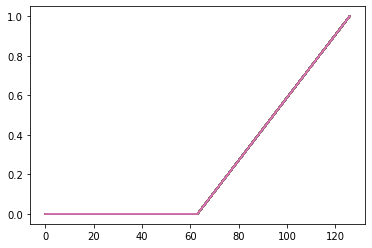

In [7]:
#Creation of a weight matrix
weights_ini_up = np.zeros((x,y))
weights_ini_down = np.zeros((x,y))
for i in range(x):
    if i <= (x-1)/2 :
        weights_ini_up[i,:]+=(1-(2*i/(x-1)))
    else:
        weights_ini_down[i,:]+=(2*(i-(x-1)/2)/(x-1))
plt.plot(weights_ini_down)

In [8]:
#Function needed for the rest of the notebook, not yet integrated at Norse, to be removed latertimesteps
def createIzhikevichSpikingBehaviour(
    a: float,
    b: float,
    c: float,
    d: float,
    v_rest: float,
    u_rest: float,
    tau_inv: float = 250,
    current: float = 1,
    print: bool = False,
    time_print : int = 250,
    timestep_print : float = 0.1
) -> IzhikevichSpikingBehaviour:
    """
    A function that allows for the creation of custom Izhikevich neurons models, as well as a visualization of their behaviour on a 250 ms time window
    """
    params = IzhikevichParameters(a=a, b=b, c=c, d=d, tau_inv=tau_inv)
    behaviour = IzhikevichSpikingBehaviour(
        p=params,
        s=IzhikevichState(
            v=torch.tensor(float(v_rest), requires_grad=True),
            u=torch.tensor(u_rest) * params.b,
        ),
    )
    if print:
        p, s = behaviour
        T1 = 20
        vs = []
        us = []
        cs = []
        time = []

        for t in np.arange(0, time_print, timestep_print):
            vs.append(s.v.item())
            us.append(s.u.item())
            time.append(t*timestep_print)

            if t > T1:
                input_current = current * torch.ones(1)
            else:
                input_current = 0 * torch.ones(1)
            _, s = izhikevich_step(input_current, s, p)
            cs.append(input_current)
        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        ax1.set_ylabel('Membrane potential (mV)')
        ax1.set_xlabel('Time (ms)')
        ax1.plot(time, vs)
        ax2 = fig.add_subplot(212)
        ax2.set_ylabel('Input current (pA)')
        ax2.set_xlabel('Time (ms)')
        ax2.plot(time, cs)
    return behaviour

/home/adridelp/testPyTorch/lib/python3.8/site-packages/numpy/core/_asarray.py:171: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return array(a, dtype, copy=False, order=order, subok=True)
/home/adridelp/testPyTorch/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, su

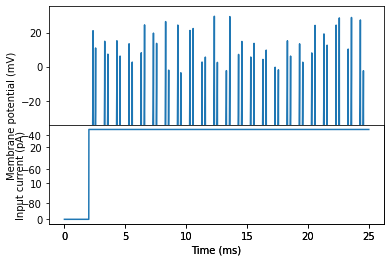

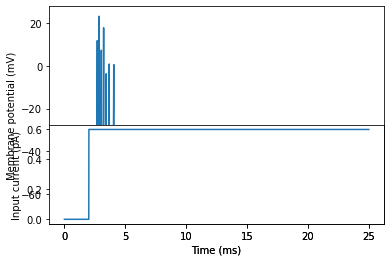

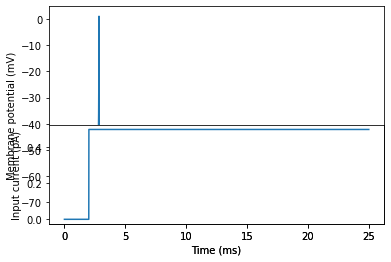

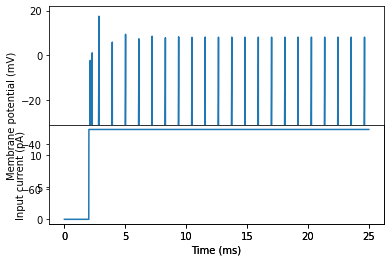

In [9]:
#Visualization of the behaviour of several neuron types used in the architecture

from norse.torch.functional.izhikevich import phasic_bursting as pb
from norse.torch.functional.izhikevich import phasic_spiking as ps
from norse.torch.functional.izhikevich import tonic_spiking as ts

LLBN_behaviour = createIzhikevichSpikingBehaviour(0.1,-0.075,-55,6,-60,-60,tau_inv=250,current=25,print=True)
pb_behaviour = createIzhikevichSpikingBehaviour(pb.p.a,pb.p.b,pb.p.c,pb.p.d,-64.0,-64.0,current=0.6,print=True)
ps_behaviour = createIzhikevichSpikingBehaviour(ps.p.a,ps.p.b,ps.p.c,ps.p.d,-64.0,-64.0,current=0.5,print=True)
ts_behaviour = createIzhikevichSpikingBehaviour(ts.p.a,ts.p.b,ts.p.c,ts.p.d,-70.0,-70.0,current=14,print=True)

In [10]:
#Creation of the neuron populations used by the architecture

weight_LLBN_input = 25*torch.ones(1)
weight_LLBN_recurrent = 25*torch.ones(1)
weight_TN_input = 30*torch.ones(1)
weight_TN_recurrent = 30*torch.ones(1)

LLBN = izk.IzhikevichRecurrentCell(1, 1, LLBN_behaviour, autapses=True, input_weights=weight_LLBN_input, recurrent_weights=weight_LLBN_recurrent, dt=dt)
EBN = izk.IzhikevichCell(phasic_bursting, dt=dt)
IFN = izk.IzhikevichCell(phasic_spiking, dt=dt)
TN = izk.IzhikevichRecurrentCell(1, 1, tonic_bursting, autapses=True, input_weights=weight_TN_input, recurrent_weights=weight_TN_recurrent, dt=dt)
MN = izk.IzhikevichCell(phasic_spiking, dt=dt)

In [11]:
#Definition of the weights that will be used in the model
weight_to_LLBN = 1
weight_to_EBN = 15
weight_LLBN_EBN = 30
weight_EBN_IFN = 100
weight_IFN_LLBN = 50
weight_EBN_TN = 35
weight_TN_MN = 200
weight_matrix = [weights_ini_down, weight_to_LLBN, weight_to_EBN, weight_LLBN_EBN, 
                 weight_EBN_IFN, weight_IFN_LLBN, weight_EBN_TN ,weight_TN_MN]

In [12]:
#Definition of the forward function
def forward_test(input_mat, weights_matrix, nb_samples, nb_repetitions, prints=False):
    tm_small = 0
    tm_big = 0
    tm_tot_start = perf_counter()
    temp = torch.zeros((1,))
    if prints:
        print_v2 = np.zeros(0)
        print_v3 = np.zeros(0)
        print_v4 = np.zeros(0)
        print_v5 = np.zeros(0)
        print_v6 = np.zeros(0)
        print_z1 = np.zeros(0)
        print_z2 = np.zeros(0)
        print_z3 = np.zeros(0)
        print_z4 = np.zeros(0)
        print_z5 = np.zeros(0)
        print_z6 = np.zeros(0)
        fig, axs = plt.subplots(11, figsize=(10,40))
    for i in range(nb_samples):
        tm1_start = perf_counter() 
        input_matrix = input_mat[i] * weights_matrix[0]
        z_1 = torch.tensor(np.reshape(input_matrix, (x*y,)))
        if prints:
            print_z1 = np.append(print_z1, z_1.detach().numpy())
        for j in range(nb_repetitions):
            if i+j == 0:
                tm2_start = perf_counter()
                z_plus = z_1.detach().numpy().sum()
                z_2, s_2 = LLBN(torch.tensor(z_plus*weights_matrix[1]-temp.detach().numpy()).float())
                z_EBN = torch.tensor(z_1.detach().numpy().sum())
                z_in = z_EBN*weights_matrix[2] + z_2*weights_matrix[3]
                z_3, s_3 = EBN(z_in)
                z_4, s_4 = IFN(z_3*weights_matrix[4])
                temp = z_4*weights_matrix[5]
                z_5, s_5 = TN(z_3.float()*weights_matrix[6])
                z_6, s_6 = MN(z_5*weights_matrix[7])
                tm2_stop = perf_counter()
                tm_small += tm2_stop-tm2_start
                if prints:
                    print_v2 = np.append(print_v2, s_2.v.detach().numpy())
                    print_z2 = np.append(print_z2, z_2.detach().numpy())
                    print_v3 = np.append(print_v3,s_3.v.detach().numpy())
                    print_z3 = np.append(print_z3, z_3.detach().numpy())
                    print_v4 = np.append(print_v4, s_4.v.detach().numpy())
                    print_z4 = np.append(print_z4, z_4.detach().numpy())
                    print_v5 = np.append(print_v5, s_5.v.detach().numpy())
                    print_z5 = np.append(print_z5, z_5.detach().numpy())
                    print_v6 = np.append(print_v6, s_6.v.detach().numpy())
                    print_z6 = np.append(print_z6, z_6.detach().numpy())                    
            else:
                tm2_start = perf_counter()
                z_plus = z_1.detach().numpy().sum()
                z_2, s_2 = LLBN(torch.tensor(z_plus*weights_matrix[1]-temp.detach().numpy()).float(), s_2)
                z_EBN = torch.tensor(z_1.detach().numpy().sum())
                z_in = z_EBN*weights_matrix[2] + z_2*weights_matrix[3]
                z_3, s_3 = EBN(z_in, s_3)
                z_4, s_4 = IFN(z_3*weights_matrix[4], s_4)
                temp = z_4*weights_matrix[5]
                z_5, s_5 = TN(z_3.float()*weights_matrix[6], s_5)
                z_6, s_6 = MN(z_5*weights_matrix[7], s_6)
                tm2_stop = perf_counter()
                tm_small += tm2_stop-tm2_start
                if prints:
                    print_v2 = np.append(print_v2, s_2.v.detach().numpy())
                    print_z2 = np.append(print_z2, z_2.detach().numpy())
                    print_v3 = np.append(print_v3,s_3.v.detach().numpy())
                    print_z3 = np.append(print_z3, z_3.detach().numpy())
                    print_v4 = np.append(print_v4, s_4.v.detach().numpy())
                    print_z4 = np.append(print_z4, z_4.detach().numpy())
                    print_v5 = np.append(print_v5, s_5.v.detach().numpy())
                    print_z5 = np.append(print_z5, z_5.detach().numpy())
                    print_v6 = np.append(print_v6, s_6.v.detach().numpy())
                    print_z6 = np.append(print_z6, z_6.detach().numpy())
        tm1_stop = perf_counter()
        tm_big += tm1_stop - tm1_start
    tm_tot_stop = perf_counter()
    t1 = tm_small/(nb_samples*nb_repetitions)
    t2 = tm_big/nb_samples
    t3 = tm_tot_stop - tm_tot_start
    if prints:
        time = [i*dt for i in range(nb_repetitions*nb_samples)]
        time2 = [i*duration/(x*y*nb_samples) for i in range(x*y*nb_samples)]
        axs[0].plot(time2,print_z1)
        axs[0].set_ylabel('Weighted spikes')
        axs[0].set_xlabel('Time (s)')
        axs[1].plot(time,print_v2)
        axs[1].set_ylabel('Membrane potential (mV)')
        axs[1].set_xlabel('Time (s)')
        axs[2].plot(time,print_z2)
        axs[2].set_ylabel('Spikes')
        axs[2].set_xlabel('Time (s)')
        axs[3].plot(time,print_v3)
        axs[3].set_ylabel('Membrane potential (mV)')
        axs[3].set_xlabel('Time (s)')
        axs[4].plot(time,print_z3)
        axs[4].set_ylabel('Spikes')
        axs[4].set_xlabel('Time (s)')
        axs[5].plot(time,print_v4)
        axs[5].set_ylabel('Membrane potential (mV)')
        axs[5].set_xlabel('Time (s)')
        axs[6].plot(time,print_z4)
        axs[6].set_ylabel('Spikes')
        axs[6].set_xlabel('Time (s)')
        axs[7].plot(time,print_v5)
        axs[7].set_ylabel('Membrane potential (mV)')
        axs[7].set_xlabel('Time (s)')
        axs[8].plot(time,print_z5)
        axs[8].set_ylabel('Spikes')
        axs[8].set_xlabel('Time (s)')
        axs[9].plot(time,print_v6)
        axs[9].set_ylabel('Membrane potential (mV)')
        axs[9].set_xlabel('Time (s)')
        axs[10].plot(time,print_z6)
        axs[10].set_ylabel('Spikes')
        axs[10].set_xlabel('Time (s)')
    return t1, t2, t3

(0.0013164304339735912, 0.021694943072303893, 1.480796743184328)

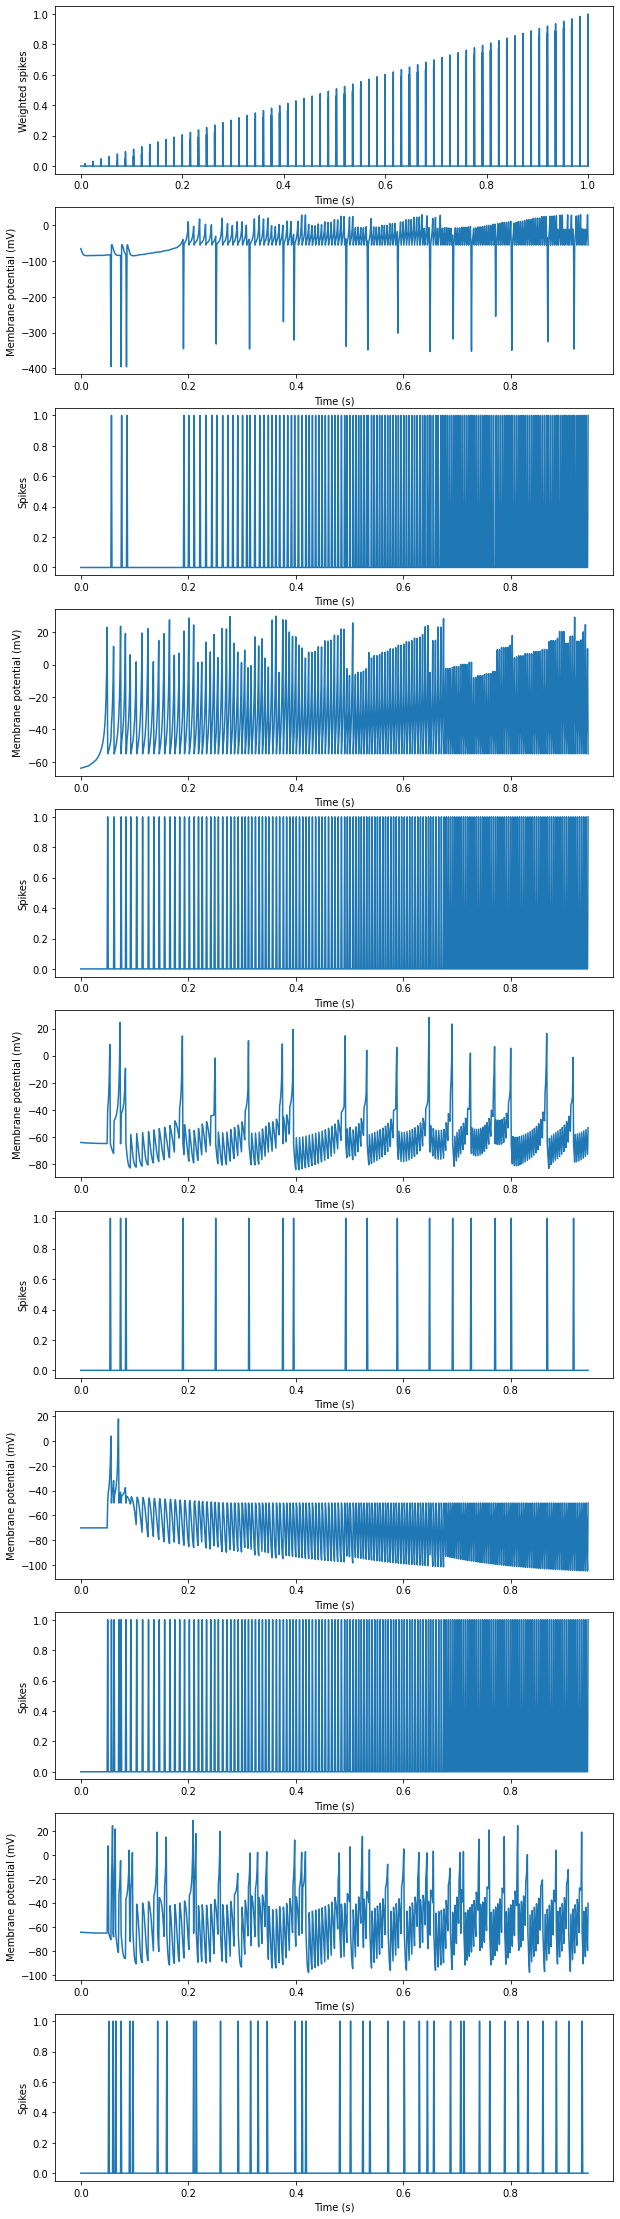

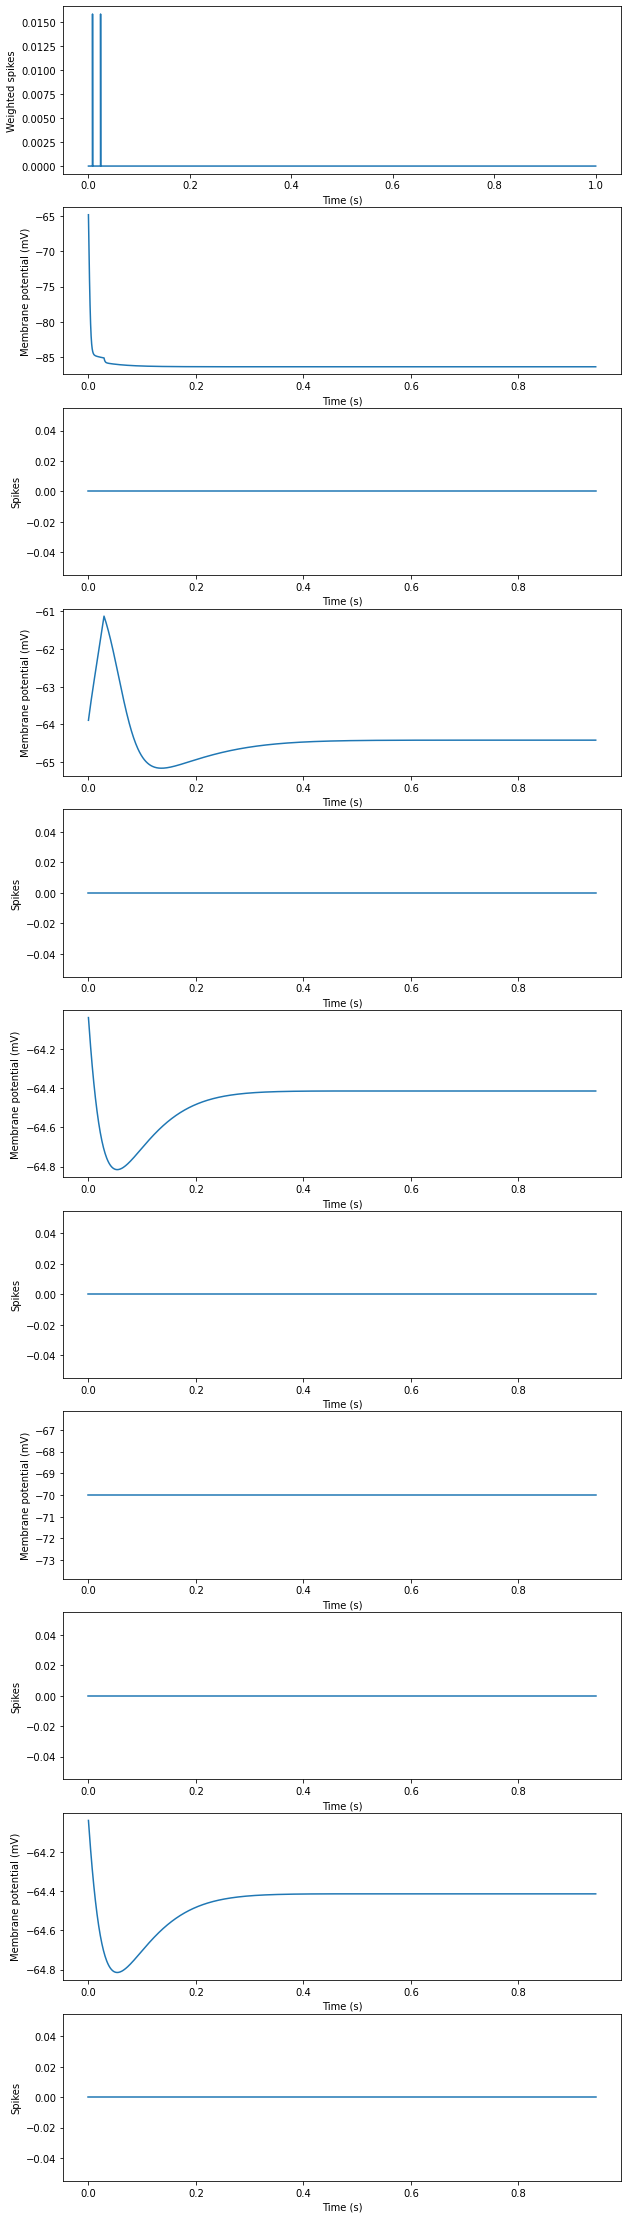

In [15]:
#Forward computation
forward_test(mvt_down, weight_matrix, nb_samples,nb_repetitions, prints=True)
forward_test(mvt_up, weight_matrix, nb_samples,nb_repetitions, prints=True)

In [14]:
"""
#Checking performance of our network

import math

nb = 200

time_frame = np.zeros((nb,))
time_sample = np.zeros((nb,))
time_mvt = np.zeros((nb,))
for i in range(nb):
    t1, t2, t3 = forward_test(mvt_up, weight_matrix, nb_samples,nb_repetitions)
    time_frame[i] = t1
    time_sample[i] = t2
    time_mvt[i] = t3
    
deviations_frame = [(x - time_frame.mean()) ** 2 for x in time_frame]
deviations_sample = [(x - time_sample.mean()) ** 2 for x in time_sample]
deviations_mvt = [(x - time_mvt.mean()) ** 2 for x in time_mvt]

variance_frame = sum(deviations_frame) / nb
variance_sample = sum(deviations_sample) / nb
variance_mvt = sum(deviations_mvt) / nb

sd_frame = math.sqrt(variance_frame)
sd_sample = math.sqrt(variance_sample)
sd_mvt = math.sqrt(variance_mvt)

print(1000*time_frame.mean(), 1000*sd_frame)
print(1000*time_sample.mean(), 1000*sd_sample)
print(1000*time_mvt.mean(), 1000*sd_mvt)
"""

'\n#Checking performance of our network\n\nimport math\n\nnb = 200\n\ntime_frame = np.zeros((nb,))\ntime_sample = np.zeros((nb,))\ntime_mvt = np.zeros((nb,))\nfor i in range(nb):\n    t1, t2, t3 = forward_test(mvt_up, weight_matrix, nb_samples,nb_repetitions)\n    time_frame[i] = t1\n    time_sample[i] = t2\n    time_mvt[i] = t3\n    \ndeviations_frame = [(x - time_frame.mean()) ** 2 for x in time_frame]\ndeviations_sample = [(x - time_sample.mean()) ** 2 for x in time_sample]\ndeviations_mvt = [(x - time_mvt.mean()) ** 2 for x in time_mvt]\n\nvariance_frame = sum(deviations_frame) / nb\nvariance_sample = sum(deviations_sample) / nb\nvariance_mvt = sum(deviations_mvt) / nb\n\nsd_frame = math.sqrt(variance_frame)\nsd_sample = math.sqrt(variance_sample)\nsd_mvt = math.sqrt(variance_mvt)\n\nprint(1000*time_frame.mean(), 1000*sd_frame)\nprint(1000*time_sample.mean(), 1000*sd_sample)\nprint(1000*time_mvt.mean(), 1000*sd_mvt)\n'